In [1]:
from tiff_processing_utils import tile_tiff_pair, tile_tiff_triplet, rasterize_shapefile
from sentinel_hub_utils import call_s2l2a_api
from torchgeo.models import resnet18, get_weight
import torch
import numpy as np
import psutil
import os
import gc
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
from models import LatentSpaceExtractor
from utils import *
from Datasets import *

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

# Optional (for reproducibility in CUDA):
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Functions to monitor memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

# Function to append data to memory-mapped file
def append_to_memmap(file_path, data, dtype):
    if not os.path.exists(file_path):
        print(f"Creating new memmap file at {file_path}")
        new_memmap = np.lib.format.open_memmap(file_path, mode='w+', dtype=dtype, shape=data.shape)
        new_memmap[:] = data
    else:
        # Load the existing memmap
        memmap = np.load(file_path, mmap_mode='r+')
        new_shape = (memmap.shape[0] + data.shape[0],) + memmap.shape[1:]
        
        # Create a temporary memmap with the expanded size
        temp_file_path = file_path + '.tmp'
        new_memmap = np.lib.format.open_memmap(temp_file_path, mode='w+', dtype=dtype, shape=new_shape)
        
        # Copy old data into the temporary memmap
        new_memmap[:memmap.shape[0]] = memmap[:]
        
        # Append new data
        new_memmap[memmap.shape[0]:] = data
        
        # Flush and delete the old memmap
        del memmap
        new_memmap.flush()
        
        # Replace the original file with the temporary file
        os.replace(temp_file_path, file_path)

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    x = torch.ones(1, device=DEVICE)
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    x = torch.ones(1, device=DEVICE)
    print("Using Apple Metal Performance Shaders (MPS) device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU found. Defaulting to CPU.")

Using Apple Metal Performance Shaders (MPS) device.


In [4]:
UNSCALED_BASE_PATH = '' # 3cm files base path
SCALED_BASE_PATH = 'one_meter_naip' # 1m files base path
TILE_SIZE = 224
STRIDE_SIZE = int(TILE_SIZE * 0.75) # stride used when tiling

# Tiled file names
TILED_DRONE_FILE = os.path.join(SCALED_BASE_PATH, f'{TILE_SIZE}naip_dataset_drone_V1.npy')
# TILED_LABEL_FILE = os.path.join(SCALED_BASE_PATH, f'{TILE_SIZE}naip_dataset_label.npy')
TILED_SATELLITE_FILE = os.path.join(SCALED_BASE_PATH, f'{TILE_SIZE}naip_dataset_satellite_V1.npy')

# Latent file names
LATENT_DRONE_FILE = os.path.join(SCALED_BASE_PATH, f'{TILE_SIZE}final_naip_latent_dataset_drone_V1_512.npy')
LATENT_SATELLITE_FILE = os.path.join(SCALED_BASE_PATH, f'{TILE_SIZE}final_naip_latent_dataset_satellite_V1_512.npy')

# List of TILED_SATELLITE_FILE names to calculate standardization mean and sd from
LIST_TILED_SATELLITE_FILE = [
    '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_naip/224naip_dataset_satellite_V1.npy',
    '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_naip/224naip_dataset_satellite_V2.npy'
]

# RGB and Satellite metrics
RGB_MEANS = [0.485, 0.456, 0.406]
RGB_SDS = [0.229, 0.224, 0.225]
'''
SATELLITE_MEANS, SATELLITE_SDS = calculate_band_stats(LIST_TILED_SATELLITE_FILE)
SATELLITE_SDS[10] = 1e-6 # So we don't get divide by 0 error during normalization
print(f"SATELLITE_MEANS: {SATELLITE_MEANS}")
print(f"SATELLITE_SDS: {SATELLITE_SDS}")
'''
SATELLITE_MEANS = [0.026770996230905415, 0.09145129995394104, 0.1374701370800858, 0.12629982008698087, 0.08348537283615888, 0.15234747745903673, 0.1755682088182016, 0.19574084608396258, 0.1958724138455955, 0.19676238458042725, 0.0, 0.15115207971951478, 0.0945010388495151]
SATELLITE_SDS = [0.035945900674540114, 0.09533489898570938, 0.1089656215582545, 0.11637876785009475, 0.0598930857979902, 0.10018866040486654, 0.11469476295117267, 0.1271611062494966, 0.1263377774611167, 0.12642673147611674, 1e-06, 0.11149914947615584, 0.07974405349672085]

# reshape and remake means/sds arrays into tensors
RGB_MEANS_TENSOR = torch.tensor(RGB_MEANS, dtype=torch.float32).view(3, 1, 1).to(DEVICE)
RGB_SDS_TENSOR = torch.tensor(RGB_SDS, dtype=torch.float32).view(3, 1, 1).to(DEVICE)
SATELLITE_MEANS_TENSOR = torch.tensor(SATELLITE_MEANS, dtype=torch.float32).view(13, 1, 1).to(DEVICE)
SATELLITE_SDS_TENSOR = torch.tensor(SATELLITE_SDS, dtype=torch.float32).view(13, 1, 1).to(DEVICE)

# RAM thresholds
TOTAL_RAM_MB = psutil.virtual_memory().total / (1024 ** 2)
SAFE_RAM_USAGE_MB = TOTAL_RAM_MB - 16 * 1024  # 16GB below total RAM
CHUNK_BUFFER_SIZE = 5  # Number of chunks to keep in memory at a time

The processing pipeline assumes that the data in the Chunks folder is in the following format:
- Each chunk is in it's own folder and named 'Chunk x' or 'Chunk x x-x'
- The RGB tif should be named 'Chunkx.tif' or 'Chunkx_x-x.tif'
- label shape file and corresponding label files should be in a folder called 'labels' inside of the matching 'Chunk x' / 'Chunk x x-x' folder, the names of the files do not need to be formatted.

In [5]:
# Generate labels.tif for all orignal Chunk folders

# for entry in os.listdir(unscaled_base_path):
#     if 'Chunk' in entry:
#         # create labels.tif
#         chunk_path = os.path.join(unscaled_base_path, entry)
#         rasterized_shape = rasterize_shapefile(chunk_path)
# print('\nDone generating labels.tif for all Chunks')

In [6]:
# STOP
# Run resampling.py to scale original Chunk folders to 1m/pixel
# Scaled Chunk folders should have a Chunk{...}.tif, labels.tif, and satellite.tif file
# Then run all remaining cells to generate dataset from Scaled Chunks

# Generate satellite.tif for all scaled Chunk folders

# for entry in os.listdir(scaled_base_path):
#     if 'Chunk' in entry:
#         chunk_path = os.path.join(scaled_base_path, entry)
#         call_s2l2a_api(chunk_path) # create satellite.tif
# print('\nDone pulling satellite.tif for all Chunks')

In [7]:
"""
Convert all tif pairs into tiled datasets

NOTE: This will take a lot of time, memory, and storage space.
You should have at least 32GB of RAM and triple the chunk folder size of storage. If you don't have enough RAM,
you can run this script in smaller chunks by lowering the CHUNK_BUFFER_SIZE variable.
"""

'''
# Buffer for storing data before appending to memmap
drone_buffer = []
label_buffer = []
satellite_buffer = []

num_chunks = len([entry for entry in os.listdir(SCALED_BASE_PATH) if 'Chunk' in entry])
print(f"Processing {num_chunks} chunk directories")

# Iterate over each chunk directory and process TIFF pairs
current_chunk = 0
for entry in os.listdir(SCALED_BASE_PATH):
    if 'Chunk' in entry:
        current_chunk += 1
        print(f"\nChunk {current_chunk}/{num_chunks}")
        chunk_path = os.path.join(SCALED_BASE_PATH, entry)
        
        # Generate tiled images and labels
        drone_images, labels, satellite_images = tile_tiff_triplet(chunk_path, image_size=TILE_SIZE, stride_size=STRIDE_SIZE)
        if drone_images.shape[0] == 0:
            print(f"No valid tiles found at {entry}")
            continue
        
        # Add to buffer
        drone_buffer.append(drone_images)
        label_buffer.append(labels)
        satellite_buffer.append(satellite_images)

        # Check memory usage and append to memmap if within threshold
        current_memory_usage = get_memory_usage()
        if current_memory_usage > SAFE_RAM_USAGE_MB or current_chunk % CHUNK_BUFFER_SIZE == 0:
            if current_memory_usage > SAFE_RAM_USAGE_MB:
                print(f"Memory usage {current_memory_usage:.2f} MB exceeds {SAFE_RAM_USAGE_MB} threshold. Appending to memmap.")
            else:
                print("Appending to memmap...")
            drone_to_append = np.concatenate(drone_buffer, axis=0)
            label_to_append = np.concatenate(label_buffer, axis=0)
            satellite_to_append = np.concatenate(satellite_buffer, axis=0)
            append_to_memmap(TILED_DRONE_FILE, drone_to_append, np.uint8)
            append_to_memmap(TILED_LABEL_FILE, label_to_append, np.uint8)
            append_to_memmap(TILED_SATELLITE_FILE, satellite_to_append, np.uint8)
            
            # Clear buffer
            drone_buffer = []
            label_buffer = []
            satellite_buffer = []
            
            # Memory management
            print_memory_usage()
            del drone_to_append, label_to_append, satellite_to_append
            gc.collect()

# Final append if buffer is not empty
if drone_buffer:
    print("Appending remaining buffered data to memmap.")
    drone_buffer = np.concatenate(drone_buffer, axis=0)
    label_buffer = np.concatenate(label_buffer, axis=0)
    satellite_buffer = np.concatenate(satellite_buffer, axis=0)
    append_to_memmap(TILED_DRONE_FILE, drone_buffer, np.uint8)
    append_to_memmap(TILED_LABEL_FILE, label_buffer, np.uint8)
    append_to_memmap(TILED_SATELLITE_FILE, satellite_buffer, np.uint8)
    
    # Clear buffer
    drone_buffer = []
    label_buffer = []
    satellite_buffer = []

print('\nDone tiling tif pairs')
'''

'\n# Buffer for storing data before appending to memmap\ndrone_buffer = []\nlabel_buffer = []\nsatellite_buffer = []\n\nnum_chunks = len([entry for entry in os.listdir(SCALED_BASE_PATH) if \'Chunk\' in entry])\nprint(f"Processing {num_chunks} chunk directories")\n\n# Iterate over each chunk directory and process TIFF pairs\ncurrent_chunk = 0\nfor entry in os.listdir(SCALED_BASE_PATH):\n    if \'Chunk\' in entry:\n        current_chunk += 1\n        print(f"\nChunk {current_chunk}/{num_chunks}")\n        chunk_path = os.path.join(SCALED_BASE_PATH, entry)\n\n        # Generate tiled images and labels\n        drone_images, labels, satellite_images = tile_tiff_triplet(chunk_path, image_size=TILE_SIZE, stride_size=STRIDE_SIZE)\n        if drone_images.shape[0] == 0:\n            print(f"No valid tiles found at {entry}")\n            continue\n\n        # Add to buffer\n        drone_buffer.append(drone_images)\n        label_buffer.append(labels)\n        satellite_buffer.append(satellite_

In [8]:
"""
Convert image space numpy files into latent space numpy files
by encoding each image (drone or satellite) through the LatentSpaceEncoder class
"""

# Open tile files
drone_tiles = np.load(TILED_DRONE_FILE, mmap_mode="r") # shape (B, C, H, W)
dB, dC, dH, dW = drone_tiles.shape
# print(f"drone_tiles dtype: {drone_tiles.dtype}. min={drone_tiles.min()} max={drone_tiles.max()}")
satellite_tiles = np.load(TILED_SATELLITE_FILE, mmap_mode="r")
sB, sC, sH, sW = satellite_tiles.shape
# print(f"satellite_tiles dtype: {satellite_tiles.dtype}. min={satellite_tiles.min()} max={satellite_tiles.max()}")
assert dB == sB, "drone tiles and satellite tiles have different batch lengths"
print(f"Drone tiles has shape ({dB}, {dC}, {dH}, {dW}). Satellite tiles has shape ({sB}, {sC}, {sH}, {sW})")

# Construct LatentSpaceExtractor
LSE = LatentSpaceExtractor().to(DEVICE).eval()

# Get latent space shape
with torch.no_grad():
    dummy_drone = torch.zeros(1, dC, dH, dW, device=DEVICE)
    out_drone = LSE(dummy_drone)

    dummy_sat = torch.zeros(1, sC+1, sH, sW, device=DEVICE)
    out_sat = LSE(dummy_sat)
_, ldC, ldH, ldW = out_drone.shape
_, lsC, lsH, lsW = out_sat.shape
print(f"Drone latent space shape will be (B, {ldC}, {ldH}, {ldW})")
print(f"Sat latent space shape will be (B, {lsC}, {lsH}, {lsW})")


# Buffer for storing data before appending to memmap
latent_drone_buffer = []
latent_satellite_buffer = []

with torch.no_grad():
  for batch_idx in range(dB):
      drone_tensor = torch.tensor(drone_tiles[batch_idx], dtype=torch.float32).to(DEVICE)
      drone_tensor.div_(255.0)
      drone_tensor = normalize_image(drone_tensor, RGB_MEANS_TENSOR, RGB_SDS_TENSOR)

      sat_tensor = torch.tensor(satellite_tiles[batch_idx], dtype=torch.float32).to(DEVICE)
      zero_channel = torch.zeros(1, sH, sW, device=DEVICE)
      sat_tensor = torch.cat((sat_tensor[0:10], zero_channel, sat_tensor[10:]), dim=0)
      sat_tensor.div_(255.0)
      sat_tensor = normalize_image(sat_tensor, SATELLITE_MEANS_TENSOR, SATELLITE_SDS_TENSOR)

      assert drone_tensor.shape[0] == 3, "drone_tensor does not have 3 channels"
      assert sat_tensor.shape[0] == 13, "sat_tensor does not have 13 channels"
      if torch.any(torch.isnan(sat_tensor)):
          print(f"sat_tensor contains NaNs after normalization")
      
      if (batch_idx % 1000 == 0):
          print(f"Processing batch_idx={batch_idx}")
          print(f"First 10 values of normalized drone_tensor: {drone_tensor.cpu().numpy().flatten()[:10]}")
          print(f"First 10 values of normalized sat_tensor: {sat_tensor.cpu().numpy().flatten()[:10]}")
          print(f"Range of normalized drone_tensor: min={drone_tensor.min().item()} max={drone_tensor.max().item()}")
          print(f"Range of normalized sat_tensor: min={sat_tensor.min().item()} max={sat_tensor.max().item()}")

      drone_latent = LSE(drone_tensor.unsqueeze(0)).cpu().numpy()
      sat_latent = LSE(sat_tensor.unsqueeze(0)).cpu().numpy()

      if (batch_idx % 1000 == 0):
          print(f"First 5 values of drone_latent: {drone_latent.flatten()[:5]}")
          print(f"First 5 values of sat_latent: {sat_latent.flatten()[:5]}")
          print(f"Range of drone_latent: min={drone_latent.min().item()} max={drone_latent.max().item()}")
          print(f"Range of sat_latent: min={sat_latent.min().item()} max={sat_latent.max().item()}")
          print(f"\n")

      # Add to buffer
      latent_drone_buffer.append(drone_latent)
      latent_satellite_buffer.append(sat_latent)

      # Check memory usage and append to memmap if within threshold
      current_memory_usage = get_memory_usage()
      if current_memory_usage > SAFE_RAM_USAGE_MB:
          print(f"Memory usage {current_memory_usage:.2f} MB exceeds {SAFE_RAM_USAGE_MB} threshold. Appending to memmap.")
          drone_to_append = np.concatenate(latent_drone_buffer, axis=0)
          satellite_to_append = np.concatenate(latent_satellite_buffer, axis=0)
          append_to_memmap(LATENT_DRONE_FILE, drone_to_append, dtype=np.float32)
          append_to_memmap(LATENT_SATELLITE_FILE, satellite_to_append, dtype=np.float32)
          
          # Clear buffer
          latent_drone_buffer = []
          latent_satellite_buffer = []
          
          # Memory management
          print_memory_usage()
          del drone_to_append, satellite_to_append
          gc.collect()

# Final append if buffer is not empty
if latent_drone_buffer:
    print("Appending remaining buffered data to memmap.")
    latent_drone_buffer = np.concatenate(latent_drone_buffer, axis=0)
    latent_satellite_buffer = np.concatenate(latent_satellite_buffer, axis=0)
    append_to_memmap(LATENT_DRONE_FILE, latent_drone_buffer, dtype=np.float32)
    append_to_memmap(LATENT_SATELLITE_FILE, latent_satellite_buffer, dtype=np.float32)
    
    # Clear buffer
    latent_drone_buffer = []
    latent_satellite_buffer = []

print('\nDone mass encoding images into latent space')


Drone tiles has shape (45540, 3, 224, 224). Satellite tiles has shape (45540, 12, 224, 224)
✅ All center layers found
✅ Pretrained center layers successfully loaded into drone_RNUNNoSkip
✅ Pretrained center layers successfully loaded into satellite_RNUNNoSkip
0.6512200236320496 and 0.6512
0.6512200236320496 and 0.6512
Drone latent space shape will be (B, 512, 7, 7)
Sat latent space shape will be (B, 512, 7, 7)
Processing batch_idx=0
First 10 values of normalized drone_tensor: [-1.2445416 -1.3130406 -1.3472902 -1.2616663 -1.2787911 -1.4157891
 -1.3130406 -1.3986644 -1.3644148 -1.2787911]
First 10 values of normalized sat_tensor: [0.67349535 0.67349535 0.67349535 0.67349535 0.67349535 0.67349535
 0.67349535 0.67349535 0.67349535 0.67349535]
Range of normalized drone_tensor: min=-1.552787184715271 max=0.5310677289962769
Range of normalized sat_tensor: min=-1.4572656154632568 max=0.6861227750778198
First 5 values of drone_latent: [0. 0. 0. 0. 0.]
First 5 values of sat_latent: [0. 0. 0. 0. 

In [9]:
drone_latents = np.load(LATENT_DRONE_FILE, "r")
satellite_latents = np.load(LATENT_SATELLITE_FILE, "r")
print(f"drone_latents dtype: {drone_latents.dtype}. min={drone_latents.min()} max={drone_latents.max()}")
print(f"sat_latents dtype: {satellite_latents.dtype}. min={satellite_latents.min()} max={satellite_latents.max()}")

ldB, ldC, ldH, ldW = drone_latents.shape
lsB, lsC, lsH, lsW = satellite_latents.shape
print(f"Drone latent space shape: ({ldB}, {ldC}, {ldH}, {ldW})")
print(f"Sat latent space shape: ({lsB}, {lsC}, {lsH}, {lsW})")

drone_latents dtype: float32. min=0.0 max=4.294843673706055
sat_latents dtype: float32. min=0.0 max=5.155717849731445
Drone latent space shape: (45540, 512, 7, 7)
Sat latent space shape: (45540, 512, 7, 7)


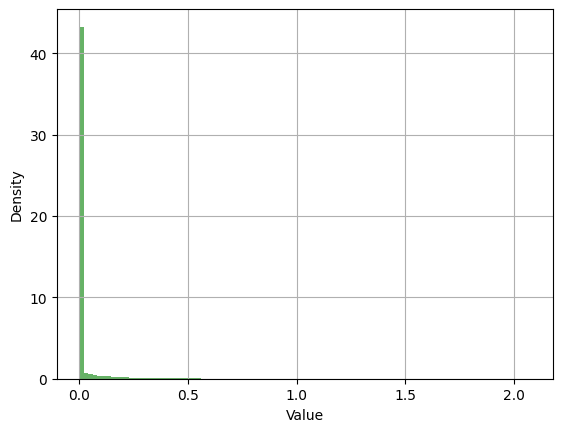

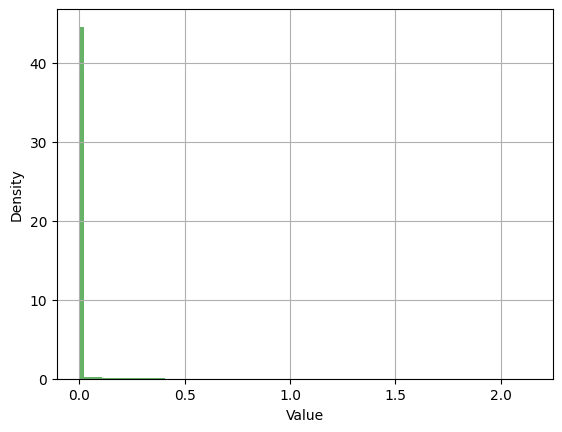

0.0 4.2948437 0.01964799 0.08163241
0.0 5.155718 0.00974653 0.060958225


In [10]:
plot_latent_distribution(drone_latents)
plot_latent_distribution(satellite_latents)
print(drone_latents.min(), drone_latents.max(), drone_latents.mean(), drone_latents.std())
print(satellite_latents.min(), satellite_latents.max(), satellite_latents.mean(), satellite_latents.std())

In [11]:
# If labels.tif files are no longer needed

# for entry in os.listdir(base_path):
#     if 'Chunk' in entry:
#         chunk_path = os.path.join(base_path, entry)
#         os.remove(os.path.join(chunk_path, 'labels.tif'))

In [12]:
# Visualize all 12 bands of satellite.tif
# Band information given here: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/
# band_names = ["B01 Coastal aerosol (60m)", "B02 Blue (10m)", "B03 Green (10m)", "B04 Red (10m)",
#               "B05 Red Edge 1 (20m)", "B06 Red Edge 2 (20m)", "B07 Red Edge 3 (20m)", "B08 NIR (10m)",
#               "B8A Narrow NIR (20m)", "B09 Water Vapor (60m)", "B11 SWIR 1 (20m)", "B12 SWIR 2 (20m)"
#               ]

# with rasterio.open('') as f:
#     bands = f.indexes
#     n_bands = len(bands)
#     n_cols = 4
#     n_rows = (n_bands + n_cols - 1) // n_cols
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
#     axes = axes.flatten()

#     for idx, (ax, b) in enumerate(zip(axes, bands)):
#         arr = f.read(b)
#         show(arr, ax=ax, cmap="magma", title=f"{band_names[idx]}")
#         ax.axis('off')

#     fig.tight_layout()
#     plt.show()